This is a notebook, used in the screencast video. Note, that the data files are not present here in Jupyter hub and you will not be able to run it. But you can always download the notebook to your local machine as well as the competition data and make it interactive. 

In [1]:
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn

In [2]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull())
            if i>=j:
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else:
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

In [3]:
def hist_it1(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    plt.ylim((0,1))

# Read the data

In [4]:
train = pd.read_csv('train.csv.zip')
Y = train.target

In [5]:
test = pd.read_csv('test.csv.zip')
test_ID = test.ID

# Data overview

Probably the first thing you check is the shapes of the train and test matrices and look inside them.

In [6]:
print 'Train shape', train.shape
print 'Test shape',  test.shape

Train shape (145231, 1934)
Test shape (145232, 1933)


In [10]:
train.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [11]:
test.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934
0,1,R,360,25,2251,B,2.0,2.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
1,3,R,74,192,3274,C,2.0,3.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
2,6,R,21,36,3500,C,1.0,1.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
3,9,R,8,2,1500,B,0.0,0.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS
4,10,H,91,39,84500,C,8.0,3.0,False,False,...,0,98,98,998,999999998,998,998,9998,9998,IAPS


There are almost 2000 anonymized variables! It's clear, some of them are categorical, some look like numeric. Some numeric feateures are integer typed, so probably they are event conters or dates. And others are of float type, but from the first few rows they look like integer-typed too, since fractional part is zero, but pandas treats them as `float` since there are NaN values in that features.   

From the first glance we see train has one more column `target` which we should not forget to drop before fitting a classifier. We also see `ID` column is shared between train and test, which sometimes can be succesfully used to improve the score.

It is also useful to know if there are any NaNs in the data. You should pay attention to columns with NaNs and the number of NaNs for each row can serve as a nice feature later.

In [13]:
# Number of NaNs for each object
train.isnull().sum(axis=1).head(15)

0     25
1     19
2     24
3     24
4     24
5     24
6     24
7     24
8     16
9     24
10    22
11    24
12    17
13    24
14    24
dtype: int64

In [14]:
# Number of NaNs for each column
train.isnull().sum(axis=0).head(15)

ID           0
VAR_0001     0
VAR_0002     0
VAR_0003     0
VAR_0004     0
VAR_0005     0
VAR_0006    56
VAR_0007    56
VAR_0008    56
VAR_0009    56
VAR_0010    56
VAR_0011    56
VAR_0012    56
VAR_0013    56
VAR_0014    56
dtype: int64

Just by reviewing the head of the lists we immediately see the patterns, exactly 56 NaNs for a set of variables, and 24 NaNs for objects. 

# Dataset cleaning

### Remove constant features

All 1932 columns are anonimized which makes us to deduce the meaning of the features ourselves. We will now try to clean the dataset. 

It is usually convenient to concatenate train and test into one dataframe and do all feature engineering using it.

In [15]:
traintest = pd.concat([train, test], axis = 0)

First we schould look for a constant features, such features do not provide any information and only make our dataset larger. 

In [16]:
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = train.nunique(dropna = False)

In [17]:
feats_counts.sort_values()[:10]

VAR_0213    1
VAR_0207    1
VAR_0840    1
VAR_0847    1
VAR_1428    1
VAR_1165    2
VAR_0438    2
VAR_1164    2
VAR_1163    2
VAR_1162    2
dtype: int64

We found 5 constant features. Let's remove them.

In [18]:
constant_features = feats_counts.loc[feats_counts==1].index.tolist()
print (constant_features)


traintest.drop(constant_features,axis = 1,inplace=True)

['VAR_0207', 'VAR_0213', 'VAR_0840', 'VAR_0847', 'VAR_1428']


### Remove duplicated features

Fill NaNs with something we can find later if needed.

In [19]:
traintest.fillna('NaN', inplace=True)

Now let's encode each feature, as we discussed. 

In [32]:
train_enc =  pd.DataFrame(index = train.index)

for col in tqdm_notebook(traintest.columns):
    train_enc[col] = train[col].factorize()[0]

We could also do something like this:

In [33]:
# train_enc[col] = train[col].map(train[col].value_counts())

The resulting data frame is very very large, so we cannot just transpose it and use .duplicated. That is why we will use a simple loop.

In [34]:
dup_cols = {}

for i, c1 in enumerate(tqdm_notebook(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
            dup_cols[c2] = c1

In [36]:
dup_cols

{'VAR_0009': 'VAR_0008',
 'VAR_0010': 'VAR_0008',
 'VAR_0011': 'VAR_0008',
 'VAR_0012': 'VAR_0008',
 'VAR_0013': 'VAR_0006',
 'VAR_0018': 'VAR_0008',
 'VAR_0019': 'VAR_0008',
 'VAR_0020': 'VAR_0008',
 'VAR_0021': 'VAR_0008',
 'VAR_0022': 'VAR_0008',
 'VAR_0023': 'VAR_0008',
 'VAR_0024': 'VAR_0008',
 'VAR_0025': 'VAR_0008',
 'VAR_0026': 'VAR_0008',
 'VAR_0027': 'VAR_0008',
 'VAR_0028': 'VAR_0008',
 'VAR_0029': 'VAR_0008',
 'VAR_0030': 'VAR_0008',
 'VAR_0031': 'VAR_0008',
 'VAR_0032': 'VAR_0008',
 'VAR_0038': 'VAR_0008',
 'VAR_0039': 'VAR_0008',
 'VAR_0040': 'VAR_0008',
 'VAR_0041': 'VAR_0008',
 'VAR_0042': 'VAR_0008',
 'VAR_0043': 'VAR_0008',
 'VAR_0044': 'VAR_0008',
 'VAR_0181': 'VAR_0180',
 'VAR_0182': 'VAR_0180',
 'VAR_0189': 'VAR_0188',
 'VAR_0190': 'VAR_0188',
 'VAR_0196': 'VAR_0008',
 'VAR_0197': 'VAR_0008',
 'VAR_0199': 'VAR_0008',
 'VAR_0201': 'VAR_0051',
 'VAR_0202': 'VAR_0008',
 'VAR_0203': 'VAR_0008',
 'VAR_0210': 'VAR_0208',
 'VAR_0211': 'VAR_0208',
 'VAR_0215': 'VAR_0008',


Don't forget to save them, as it takes long time to find these.

In [37]:
import cPickle as pickle
pickle.dump(dup_cols, open('dup_cols.p', 'w'), protocol=pickle.HIGHEST_PROTOCOL)

Drop from traintest.

In [38]:
traintest.drop(dup_cols.keys(), axis = 1,inplace=True)

# Determine types

Let's examine the number of unique values.

In [50]:
nunique = train.nunique(dropna=False)
nunique

ID                145231
VAR_0001               3
VAR_0002             820
VAR_0003             588
VAR_0004            7935
VAR_0005               4
VAR_0006              38
VAR_0007              36
VAR_0008               2
VAR_0009               2
VAR_0010               2
VAR_0011               2
VAR_0012               2
VAR_0013              38
VAR_0014              38
VAR_0015              27
VAR_0016              30
VAR_0017              26
VAR_0018               2
VAR_0019               2
VAR_0020               2
VAR_0021               2
VAR_0022               2
VAR_0023               2
VAR_0024               2
VAR_0025               2
VAR_0026               2
VAR_0027               2
VAR_0028               2
VAR_0029               2
                   ...  
VAR_1907              41
VAR_1908              37
VAR_1909              41
VAR_1910              37
VAR_1911             107
VAR_1912           16370
VAR_1913           25426
VAR_1914           14226
VAR_1915            1148


and build a histogram of those values

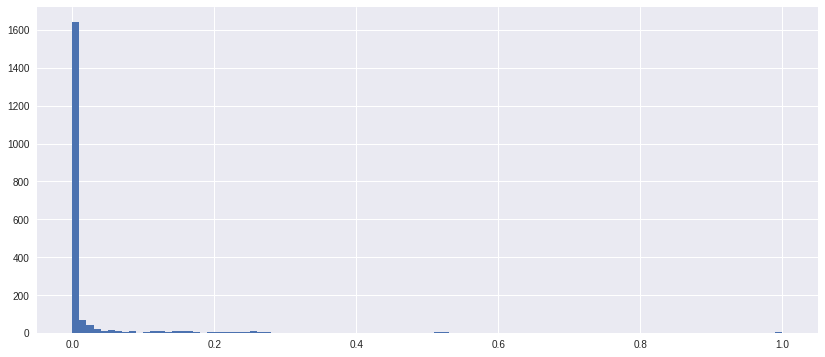

In [44]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/train.shape[0], bins=100)

Let's take a looks at the features with a huge number of unique values:

In [61]:
mask = (nunique.astype(float)/train.shape[0] > 0.8)
train.loc[:, mask]

,ID,VAR_0212,VAR_0227
0,2,NaN,311951
1,4,9.20713e+10,2.76949e+06
2,5,2.65477e+10,654127
3,7,7.75753e+10,3.01509e+06
4,8,6.04238e+10,118678
5,14,7.73796e+10,1.76557e+06
6,16,9.70303e+10,80151
7,20,3.10981e+10,853641
8,21,7.82124e+10,1.40254e+06
9,22,1.94014e+10,2.2187e+06


The values are not float, they are integer, so these features are likely to be even counts. Let's look at another pack of features.

In [64]:
mask = (nunique.astype(float)/train.shape[0] < 0.8) & (nunique.astype(float)/train.shape[0] > 0.4)
train.loc[:25, mask]

,VAR_0541,VAR_0543,VAR_0899,VAR_1081,VAR_1082,VAR_1087,VAR_1179,VAR_1180,VAR_1181
0,49463,116783,112871,76857,76857,116783,76857,76857,76857
1,303472,346196,346375,341365,341365,346196,341365,341365,176604
2,94990,122601,121501,107267,107267,121501,107267,107267,58714
3,20593,59490,61890,45794,47568,59490,45794,47568,47568
4,10071,35708,34787,20475,23647,34708,20475,23647,23647
5,18877,28055,28455,21139,21139,28055,21139,21139,20627
6,321783,333565,886886,327744,327744,333565,327744,327744,163944
7,2961,5181,11084,4326,4326,5181,4326,4326,4326
8,20359,30114,33434,24969,27128,30114,24969,27128,27128
9,815,1300,7677,1197,1197,1300,1197,1197,1197


These look like counts too. First thing to notice is the 23th line: 99999.., -99999 values look like NaNs so we should probably built a related feature. Second: the columns are sometimes placed next to each other, so the columns are probably grouped together and we can disentangle that.      

Our conclusion: there are no floating point variables, there are some counts variables, which we will treat as numeric. 

And finally, let's pick one variable (in this case 'VAR_0015') from the third group of features.

In [82]:
train['VAR_0015'].value_counts()

 0.0      102382
 1.0       28045
 2.0        8981
 3.0        3199
 4.0        1274
 5.0         588
 6.0         275
 7.0         166
 8.0          97
-999.0        56
 9.0          51
 10.0         39
 11.0         18
 12.0         16
 13.0          9
 14.0          8
 15.0          8
 16.0          6
 22.0          3
 21.0          3
 19.0          1
 35.0          1
 17.0          1
 29.0          1
 18.0          1
 32.0          1
 23.0          1
Name: VAR_0015, dtype: int64

In [5]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns)

# Go through

Let's replace NaNs with something first.

In [65]:
train.replace('NaN', -999, inplace=True)

Let's calculate how many times one feature is greater than the other and create cross tabel out of it. 

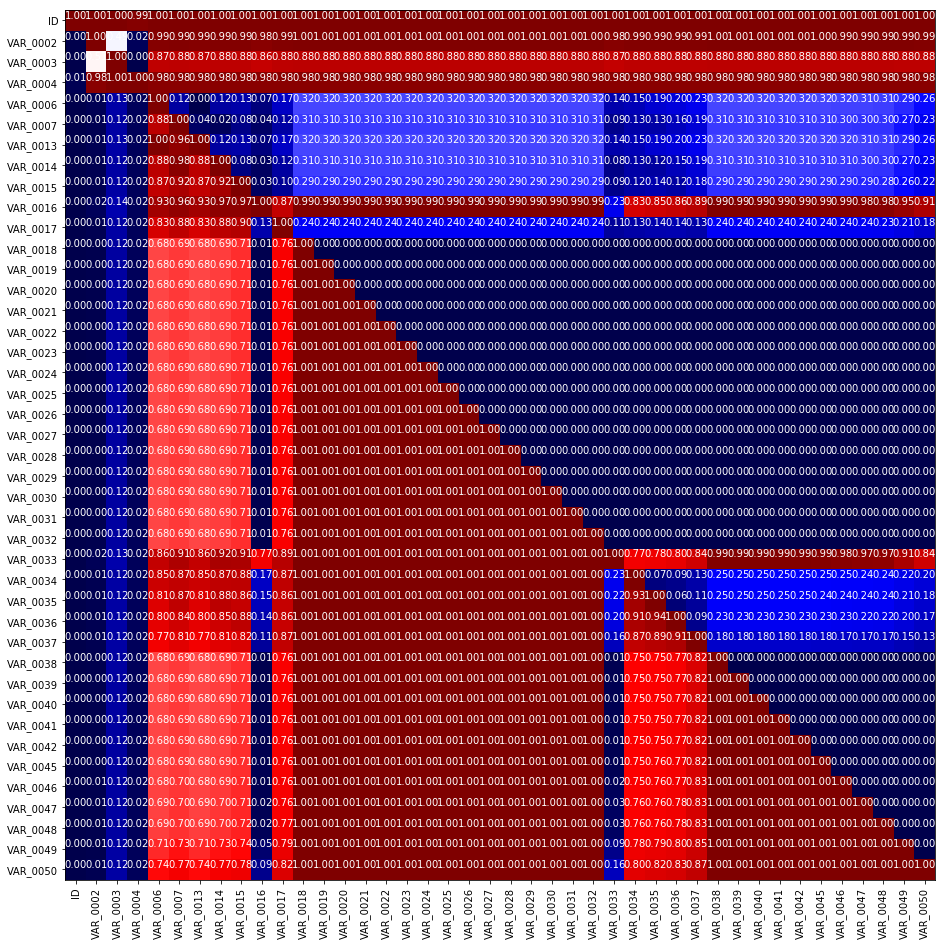

In [21]:
# select first 42 numeric features
feats = num_cols[:42]

# build 'mean(feat1 > feat2)' plot
gt_matrix(feats,16)

Indeed, we see interesting patterns here. There are blocks of geatures where one is strictly greater than the other. So we can hypothesize, that each column correspondes to cumulative counts, e.g. feature number one is counts in first month, second -- total count number in first two month and so on. So we immediately understand what features we should generate to make tree-based models more efficient: the differences between consecutive values.

## VAR_0002, VAR_0003 

(-10, 1010)

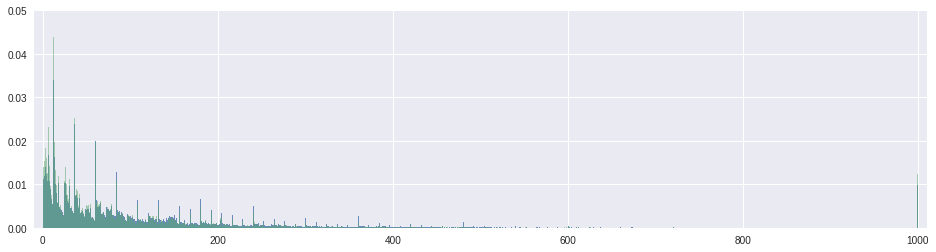

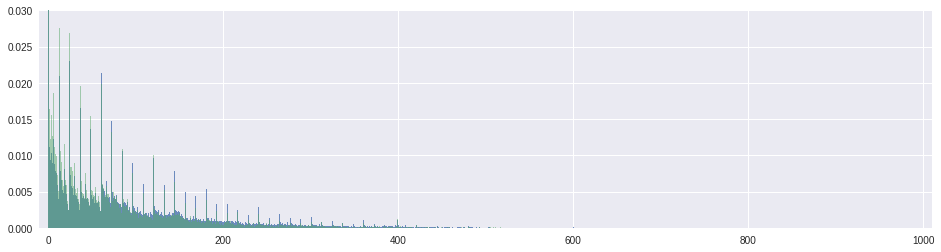

In [59]:
hist_it(train['VAR_0002'])
plt.ylim((0,0.05))
plt.xlim((-10,1010))

hist_it(train['VAR_0003'])
plt.ylim((0,0.03))
plt.xlim((-10,1010))

In [39]:
train['VAR_0002'].value_counts()

12     5264
24     4763
36     3499
60     2899
6      2657
13     2478
72     2243
48     2222
3      2171
4      1917
2      1835
84     1801
120    1786
1      1724
7      1671
26     1637
5      1624
14     1572
18     1555
8      1513
999    1510
25     1504
96     1445
30     1438
9      1306
144    1283
15     1221
27     1186
38     1146
37     1078
       ... 
877       1
785       1
750       1
653       1
784       1
764       1
751       1
797       1
926       1
691       1
808       1
774       1
902       1
755       1
656       1
814       1
813       1
685       1
739       1
935       1
906       1
807       1
550       1
933       1
804       1
675       1
674       1
745       1
778       1
851       1
Name: VAR_0002, Length: 820, dtype: int64

In [38]:
train['VAR_0003'].value_counts()

0      17436
24      3469
12      3271
60      3054
36      2498
72      2081
48      2048
6       1993
1       1797
3       1679
84      1553
2       1459
999     1428
4       1419
120     1411
7       1356
13      1297
18      1296
96      1253
14      1228
8       1216
5       1189
9       1182
30      1100
25      1100
144     1090
15      1047
61      1008
26       929
42       921
       ...  
560        1
552        1
550        1
804        1
543        1
668        1
794        1
537        1
531        1
664        1
632        1
709        1
597        1
965        1
852        1
648        1
596        1
466        1
592        1
521        1
533        1
636        1
975        1
973        1
587        1
523        1
584        1
759        1
583        1
570        1
Name: VAR_0003, Length: 588, dtype: int64

We see there is something special about 12, 24 and so on, sowe can create another feature x mod 12. 

## VAR_0004

(0, 0.6)

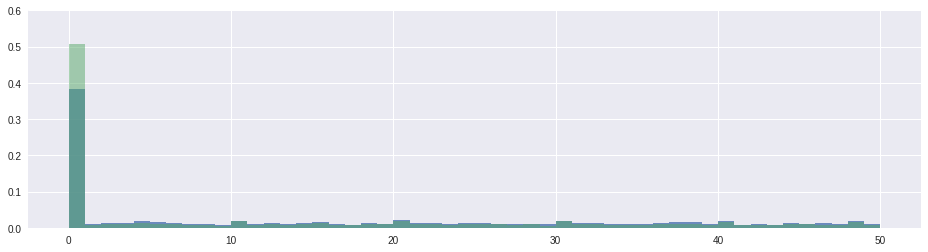

In [49]:
train['VAR_0004_mod50'] = train['VAR_0004'] % 50
hist_it(train['VAR_0004_mod50'])
plt.ylim((0,0.6))

# Categorical features

Let's take a look at categorical features we have.

In [57]:
train.loc[:,cat_cols].head().T

,0,1,2,3,4
VAR_0001,H,H,H,H,R
VAR_0005,C,B,C,C,N
VAR_0008,False,False,False,False,False
VAR_0009,False,False,False,False,False
VAR_0010,False,False,False,False,False
VAR_0011,False,False,False,False,False
VAR_0012,False,False,False,False,False
VAR_0043,False,False,False,False,False
VAR_0044,[],[],[],[],[]
VAR_0073,NaT,2012-09-04 00:00:00,NaT,NaT,NaT


`VAR_0200`, `VAR_0237`, `VAR_0274` look like some georgraphical data thus one could generate geography related features, we will talk later in the course.

There are some features, that are hard to identify, but look, there a date columns `VAR_0073` -- `VAR_0179`, `VAR_0204`, `VAR_0217`. It is useful to plot one date against another to find relationships. 

In [74]:
date_cols = [u'VAR_0073','VAR_0075',
             u'VAR_0156',u'VAR_0157',u'VAR_0158','VAR_0159',
             u'VAR_0166', u'VAR_0167',u'VAR_0168',u'VAR_0169',
             u'VAR_0176',u'VAR_0177',u'VAR_0178',u'VAR_0179',
             u'VAR_0204',
             u'VAR_0217']

for c in date_cols:
    train[c] = pd.to_datetime(train[c],format = '%d%b%y:%H:%M:%S')
    test[c] = pd.to_datetime(test[c],  format = '%d%b%y:%H:%M:%S')

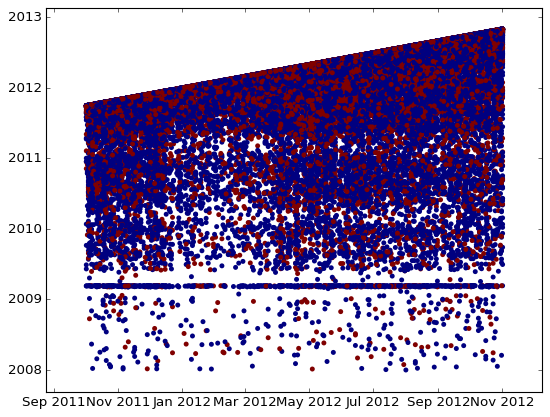

In [75]:
c1 = 'VAR_0217'
c2 = 'VAR_0073'

# mask = (~test[c1].isnull()) & (~test[c2].isnull())
# sc2(test.ix[mask,c1].values,test.ix[mask,c2].values,alpha=0.7,c = 'black')

mask = (~train[c1].isnull()) & (~train[c2].isnull())
sc2(train.loc[mask,c1].values,train.loc[mask,c2].values,c=train.loc[mask,'target'].values)

We see that one date is strictly greater than the other, so the difference between them can be a good feature. Also look at horizontal line there -- it also looks like NaN, so I would rather create a new binary feature which will serve as an idicator that our time feature is NaN.